In [158]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})


# Understand Transformer as Kernels: The math&code of physio transformers

## Transformer Preliminaries
Given an input token sequence
$$
\mathbf{x}=[x_1, x_2, ..., x_n]
$$
Drawn from a token space $\mathcal{X}$

This will be our tokens representing a signal

In [ ]:
n_epochs = 10
n_channels = 8  # AFz, Fz, FCz, Cz, CPz, Pz, POz, Oz
sampling_rate = 200  # Hz
epoch_duration = 0.9  # seconds

num_timesteps = int(sampling_rate * epoch_duration)

x_eeg = torch.randn(n_epochs, n_channels, num_timesteps)  # (n_epochs, num_channels, num_timesteps)
print(f'{x_eeg.shape = }')

x_eeg.shape = torch.Size([10, 8, 180])
x_eeg.shape = torch.Size([10, 8, 180])


Now let's turn the EEG signal into tokens, we will do this by windowing the signal.

In [ ]:
window_duration = 0.1
token_length = int(window_duration * sampling_rate)  # tau

token_embed_dim = 64
token_embedding = nn.Sequential(
    Rearrange('b c t -> b 1 c t', c=n_channels, t=num_timesteps),  # b is the number of epochs
    nn.Conv2d(1, token_embed_dim, kernel_size=(1, token_length), stride=(1, token_length), bias=True),
)

x_token = token_embedding(x_eeg)  # (n_epochs, token_embed_dim, num_channels, num_timesteps)
print(f'before merging the time and channel axes {x_token.shape = }')
x_token = x_token.flatten(2)  # (n_epochs, token_embed_dim, num_tokens)
x_token = x_token.transpose(1, 2) # (n_epochs, num_tokens, token_embed_dim)
print(f'after merging the time and channel axes, and swapping n_tokens and d_embed {x_token.shape = }')
num_tokens = x_token.shape[1]

before merging the time and channel axes x_token.shape = torch.Size([10, 64, 8, 9])
after merging the time and channel axes, and swapping n_tokens and d_embed x_token.shape = torch.Size([10, 72, 64])


Token embeddings are then fed into a Transformer block, with QKV projections.

In [ ]:
dim_head = 64
n_head = 3
#
to_qkv = nn.Linear(token_embed_dim, dim_head * n_head * 3, bias=False)  # qkv does not include bias  W: (d_{embed}, n_{head} * d_{head} * 3)
to_out = nn.Linear(dim_head * 3, token_embed_dim)  # W: (n_{head} * d_{head} * 3, d_{embed})

print(f'{to_qkv.weight.data.shape = }')
print(f'{to_out.weight.data.shape = }')

to_qkv.weight.data.shape = torch.Size([576, 64])
to_out.weight.data.shape = torch.Size([64, 192])


Apply the QKV and out projection to the token embeddings

In [ ]:
qkv = to_qkv(x_token).chunk(3, dim=-1)
q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=n_head), qkv)

print(f'{q.shape = }')

dots = torch.einsum('bhid,bhjd->bhij', q, k)  # dot product between each query key pair (n_epochs, n_head, num_tokens, num_tokens)
print(f'{dots.shape = }')

attention = nn.Softmax(dim=-1)(dots * dim_head ** -0.5)  # (n_epochs, n_head, num_tokens, num_tokens)


q.shape = torch.Size([10, 3, 72, 64])
dots.shape = torch.Size([10, 3, 72, 72])


In [ ]:
attented = torch.torch.einsum('bhij,bhjd->bhid', (attention, v))  # (n_epochs, n_head, num_tokens, d_head)
print(f'{attented.shape = }')

attented = rearrange(attented, 'b h n d -> b n (h d)')
print(f'after merging all heads {attented.shape = }')

out = to_out(attented)  # (n_epochs, num_tokens, token_embed_dim)
print(f'{out.shape = } The same shape as our input token embeddings {x_token.shape = }')

attented.shape = torch.Size([10, 3, 72, 64])
after merging all heads attented.shape = torch.Size([10, 72, 192])
out.shape = torch.Size([10, 72, 64]) The same shape as our input token embeddings x_token.shape = torch.Size([10, 72, 64])


## Nadaraya-Watson kernel-weighted average as Kernel Smoother

In [162]:

def nadaraya_watson_kernel_smoother(x, x_data, y_data, kernel_func):
    """
    Nadaraya-Watson kernel weighted average (kernel smoother) implementation.

    Arguments:
    x -- The input value(s) for which the prediction is made (can be a scalar or an array).
    x_data -- The array of input values in the training dataset.
    y_data -- The array of output values in the training dataset.
    kernel_func -- The kernel function to compute the weights.

    Returns:
    The predicted value(s) based on the Nadaraya-Watson kernel weighted average.
    """
    numerator = 0.0
    denominator = 0.0

    for i in range(len(x_data)):
        kernel_weight = kernel_func(x, x_data[i])
        numerator += kernel_weight * y_data[i]
        denominator += kernel_weight

    return numerator / denominator

Define a few different kernels

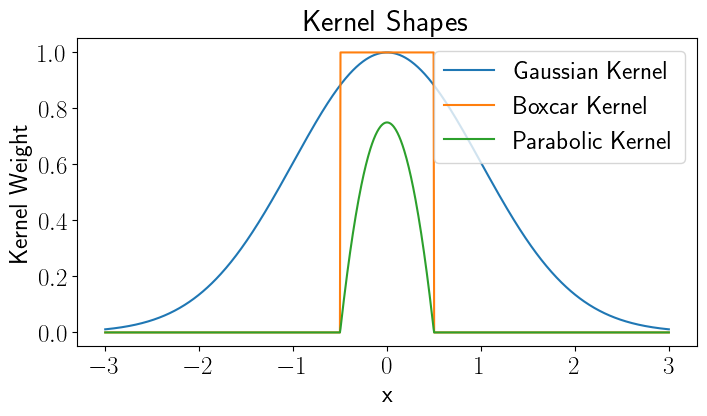

In [164]:
# Gaussian kernel function
def gaussian_kernel(x, xi, bandwidth=1):
    return np.exp(-(x - xi) ** 2 / (2 * bandwidth ** 2))

def boxcar_kernel(x, xi, bandwidth=1):
    return np.where(np.abs(x - xi) <= bandwidth/2, 1/bandwidth, 0)

def parabolic_kernel(x, xi, bandwidth=1):
    return np.where(np.abs(x - xi) <= bandwidth/2, 0.75 * (1 - ((x - xi) / (bandwidth/2))**2), 0)

x = np.linspace(-3, 3, num=1000)  # x-axis values

# Compute kernel shapes for each kernel function
gaussian_shape = gaussian_kernel(x, 0)
boxcar_shape = boxcar_kernel(x, 0)
parabolic_shape = parabolic_kernel(x, 0)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(x, gaussian_shape, label='Gaussian Kernel')
plt.plot(x, boxcar_shape, label='Boxcar Kernel')
plt.plot(x, parabolic_shape, label='Parabolic Kernel')
plt.xlabel('x')
plt.ylabel('Kernel Weight')
plt.title('Kernel Shapes')
plt.legend()
plt.show()

In [166]:
def generate_sparse_sin_data(n_samples, noise_std=0.1):
    """
    Generate sparse sinusoidal dummy data.

    Arguments:
    n_samples -- Number of samples to generate.
    noise_std -- Standard deviation of Gaussian noise added to the samples.

    Returns:
    x -- Input values with sparsely sampled points.
    y -- Corresponding output values of the sine function with added noise.
    """
    x_sparse = np.sort(np.random.choice(np.arange(0, 2*np.pi, 0.2), size=n_samples, replace=False))
    y_sparse = np.sin(x_sparse) + np.random.normal(0, noise_std, size=n_samples)
    return x_sparse, y_sparse

C:\Users\apoca\AppData\Local\Temp\ipykernel_40504\3080687146.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denominator


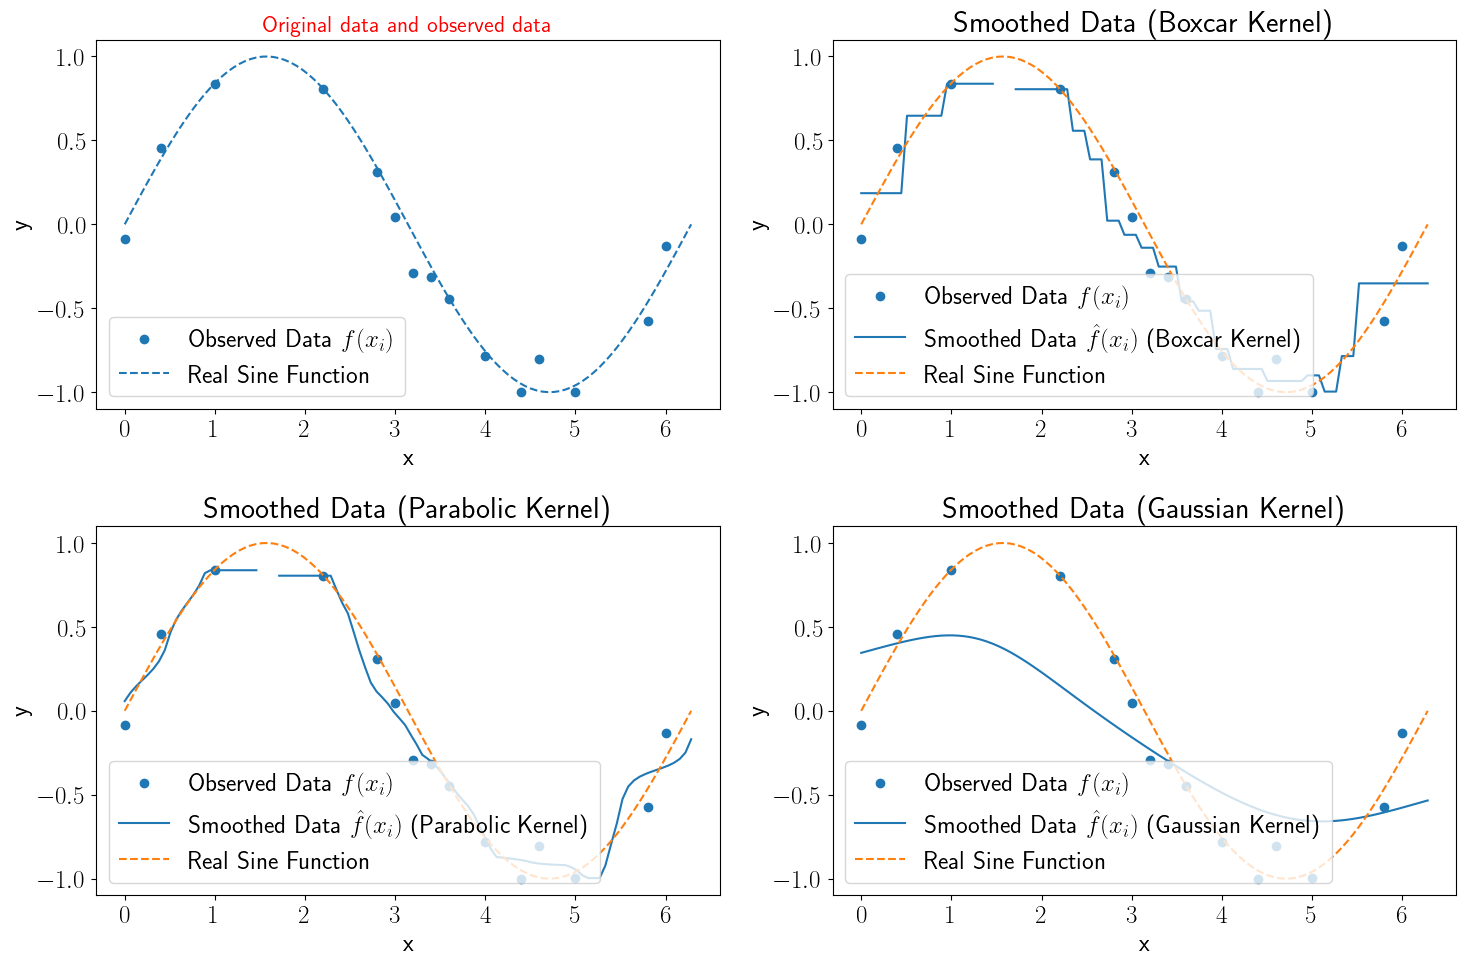

In [167]:

# Generate sparse sinusoidal dummy data
x_sparse, y_sparse = generate_sparse_sin_data(n_samples=15)

# Smooth the sparse data using Nadaraya-Watson kernel smoother
x_smooth = np.linspace(0, 2*np.pi, num=100)
y_smooth_gaussian = np.zeros_like(x_smooth)
y_smooth_boxcar = np.zeros_like(x_smooth)
y_smooth_parabolic = np.zeros_like(x_smooth)

for i in range(len(x_smooth)):
    y_smooth_gaussian[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, gaussian_kernel)
    y_smooth_boxcar[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, boxcar_kernel)
    y_smooth_parabolic[i] = nadaraya_watson_kernel_smoother(x_smooth[i], x_sparse, y_sparse, parabolic_kernel)


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Sparse Data
axs[0, 0].scatter(x_sparse, y_sparse, label=(r'Observed Data $f(x_i)$'))
axs[0, 0].plot(x_smooth, np.sin(x_smooth), linestyle='--', label='Real Sine Function')
axs[0, 0].set_title('Original data and observed data', fontsize=16, color='r')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].legend(loc='lower left')

# Boxcar Kernel
axs[0, 1].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[0, 1].plot(x_smooth, y_smooth_boxcar, label='Smoothed Data $\hat{f}(x_i)$ (Boxcar Kernel)')
axs[0, 1].plot(x_smooth, np.sin(x_smooth), linestyle='--', label='Real Sine Function')
axs[0, 1].set_title('Smoothed Data (Boxcar Kernel)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].legend(loc='lower left')

# Gaussian Kernel
axs[1, 0].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[1, 0].plot(x_smooth, y_smooth_parabolic, label='Smoothed Data $\hat{f}(x_i)$ (Parabolic Kernel)')
axs[1, 0].plot(np.linspace(0, 2*np.pi, num=100), np.sin(np.linspace(0, 2*np.pi, num=100)), linestyle='--', label='Real Sine Function')
axs[1, 0].set_title('Smoothed Data (Parabolic Kernel)')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].legend(loc='lower left')

axs[1, 1].scatter(x_sparse, y_sparse, label='Observed Data $f(x_i)$')
axs[1, 1].plot(x_smooth, y_smooth_gaussian, label='Smoothed Data $\hat{f}(x_i)$ (Gaussian Kernel)')
axs[1, 1].plot(np.linspace(0, 2*np.pi, num=100), np.sin(np.linspace(0, 2*np.pi, num=100)), linestyle='--', label='Real Sine Function')
axs[1, 1].set_title('Smoothed Data (Gaussian Kernel)')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()

## Positional Embeddings
Learnable embeddings are simply torch parameters. They are initialized randomly and updated during training. The positional embeddings are added to the token embeddings before being fed into the encoder. The positional embeddings are also updated during training.

The sinusoidal positional embeddings are functions of the position index and the dimension index. The dimension index is the index of the dimension of the token embedding. The sinusoidal positional embeddings are pre-computed and are not updated during training.

In [168]:
learnable_pos_embedding = nn.Parameter(torch.randn(1, num_tokens, token_embed_dim))  # plus 1 for the <cls> token
x_token_w_learnable_pos_embedding = x_token + learnable_pos_embedding

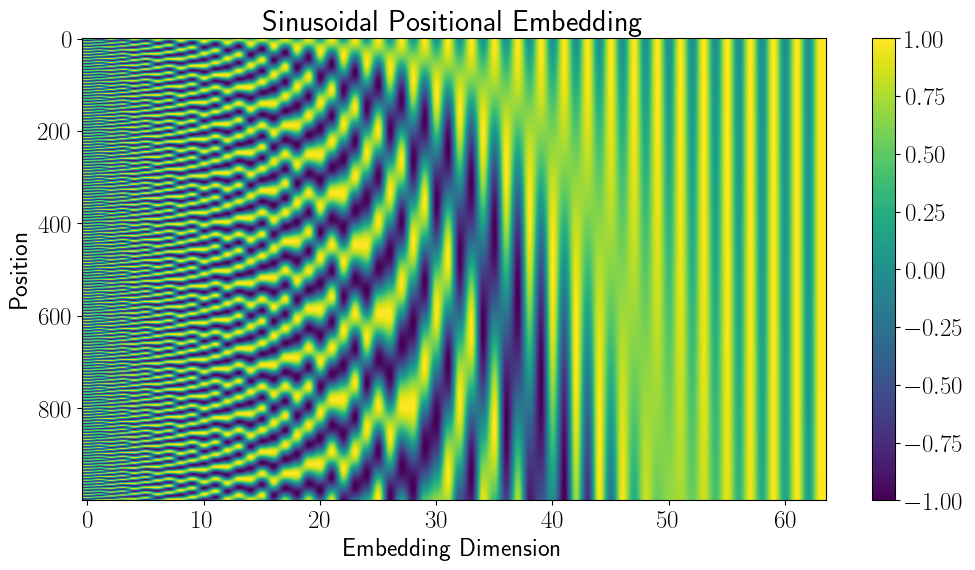

In [169]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        inverse_frequency = 1. / (10000 ** (torch.arange(0, embed_dim, 2).float() / embed_dim))
        inverse_frequency = torch.unsqueeze(inverse_frequency, dim=0)  # unsequeeze for broadcasting to batches
        self.register_buffer('inverse_frequency', inverse_frequency)

    def forward(self, p):
        outer_product = torch.einsum('bn,nd->bnd', p, self.inverse_frequency)
        pos_emb = torch.stack([outer_product.sin(), outer_product.cos()], dim=-1)
        pos_emb = pos_emb.flatten(2)
        return pos_emb

# Create an instance of the SinusoidalPositionalEmbedding module
pos_emb_module = SinusoidalPositionalEmbedding(token_embed_dim)

# Generate positional embeddings for the sequence
positions = torch.arange(1000).unsqueeze(0)
sinusoidal_positional_embeddings = pos_emb_module(positions)

# Convert the tensor to numpy array for visualization
pos_emb_np = sinusoidal_positional_embeddings.squeeze(0).numpy()

# Plot the sinusoidal positional embedding
plt.figure(figsize=(12, 6))
plt.imshow(pos_emb_np, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Sinusoidal Positional Embedding')
plt.show()

## Transformer for classification

Let's first define production code for a transformer.

In [170]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attention = self.attend(dots)
        attention = self.dropout(attention)  # TODO

        out = torch.matmul(attention, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, feedforward_mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, feedforward_mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for prenorm_attention, prenorm_feedforward in self.layers:
            out, attention = prenorm_attention(x)
            x = out + x
            x = prenorm_feedforward(x) + x
        return x, attention  # last layer


class PhysioTransformer(nn.Module):
    def __init__(self, num_timesteps, num_channels, sampling_rate, num_classes, depth=4, num_heads=8, feedforward_mlp_dim=32, window_duration=0.1, pool='cls',
                 patch_embed_dim=128, dim_head=64, attn_dropout=0.5, emb_dropout=0.5, output='multi'):
        """

        # a token is a time slice of data on a single channel

        @param num_timesteps: int: number of timesteps in each sample
        @param num_channels: int: number of channels of the input data
        @param output: str: can be 'single' or 'multi'. If 'single', the output is a single number to be put with sigmoid activation. If 'multi', the output is a vector of size num_classes to be put with softmax activation.
        note that 'single' only works when the number of classes is 2.
        """
        if output == 'single':
            assert num_classes == 2, 'output can only be single when num_classes is 2'
        super().__init__()
        self.depth = depth
        self.num_heads = num_heads
        self.window_duration = window_duration

        self.num_channels = num_channels
        self.num_timesteps = num_timesteps
        self.path_embed_dim = patch_embed_dim
        self.patch_length = int(window_duration * sampling_rate)
        self.num_windows = num_timesteps // self.patch_length

        self.grid_dims = self.num_channels, self.num_windows
        self.num_patches = self.num_channels * self.num_windows

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c t -> b 1 c t', c=self.num_channels, t=self.num_timesteps),
            nn.Conv2d(1, patch_embed_dim, kernel_size=(1, self.patch_length), stride=(1, self.patch_length), bias=True),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, patch_embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, patch_embed_dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(patch_embed_dim, depth, num_heads, dim_head, feedforward_mlp_dim, attn_dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        if output == 'single':
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(patch_embed_dim),
                nn.Linear(patch_embed_dim, 1))
        else:
            self.mlp_head = nn.Sequential(
                nn.LayerNorm(patch_embed_dim),
                nn.Linear(patch_embed_dim, num_classes))

    def forward(self, x_eeg):
            x = self.encode(x_eeg)
            return self.mlp_head(x)

    def encode(self, x_eeg):
        x = self.to_patch_embedding(x_eeg)
        x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC

        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, att_matrix = self.transformer(x)
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x

In [171]:
data_x_path = 'C:/Data/x_auditory_oddball.p'
data_y_path = 'C:/Data/y_auditory_oddball.p'

with open(data_x_path, 'rb') as f:
    data_x = pickle.load(f)
with open(data_y_path, 'rb') as f:
    data_y = pickle.load(f)

print(f"{data_x.shape = }")
print(f"{data_y.shape = }")

data_x.shape = (23502, 64, 180)
data_y.shape = (23502,)
